<a href="https://colab.research.google.com/github/Rchatru/ML4DS/blob/master/assignment_F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [2]:
import os
import numpy as np
import pandas as pd
import statistics

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Not important for now. Could be useful at the model training stage
# For installing them in Colab do:
# pip install wandb
# pip install shap
# import wandb
# import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Import the data


#### Option 1- If working in Google Colab:

1. Add the following files to your drive:
https://drive.google.com/file/d/1gKJmVCODGcpCfgVtOgUzlxH1Q1Vf0KaR/view?usp=sharing
https://drive.google.com/file/d/1nydN6iEc-WEn1ZcOw3K1vjEonAuqWWOh/view?usp=sharing
2. In the drive interface, create a shortcut for both files
3. Uncomment the cell and mount your drive using the code below

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')
#df = pd.read_csv('/content/drive/MyDrive/train.csv')

#### Option 2- Import the data locally from Github

In [60]:
filename = 'train.csv'
df = pd.read_csv(os.path.join(os.getcwd(),filename))

## EDA. Exploratory Data Analysis

### Basic Info

We have 329975 samples and 6 features. The features are: `Year`, `Month`, `Consumer_type`, `Consumption`, `Consumer_number` and `Installation_zone`.

The variables `Year`, `Month` and `Consumption` are numerical (type `int64`), while `Consumer_type`, `Consumer_number` and `Installation_zone` are textual (type `object`).

In this case the *target* variable is `Consumer_type`, which is a categorical variable with 7 possible values: `['domestic', 'industrial', 'rural commercial', 'construction', 'low income families', 'rural domestic', 'rural expansion']`. The `domestic`, `industrial` and `low income families` are self-explanatory. The rural* categories are related to agro-production consumers in varying sizes:
- rural domestic: small/familiar companies
- rural commercial: mid-sized companies
- rural expansion: others agro-production

*Note that a priori, the agro-production user's water consumption could be very season dependant (because of the crops cycles and the weather), so it could be interesting to explore this in the future.*

There are no NaN values in the dataset. But in this case, it is important to note the existence of the consumption value `0` in the feature `Consumption`. This could represent a missing value or actually, a zero water usage for that particular consumer in a specific month.

We have 7 years of data, from 2013 to 2020 (except 2015), All the years are complete, with 12 months each.

- Years available:  **[2013, 2014, 2016, 2017, 2018, 2019, 2020]**
- Months:  **[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]**
- Consumer types:  **['domestic', 'industrial', 'rural commercial', 'construction', 'low income families', 'rural domestic', 'rural expansion']**
- Number of Installation zones: **49**, values from **Installation_zone 1 to Installation_zone 49**
- Number of unique Consumers:  **27632**
- Consumption values ranging from **0 to 4978 m3**
- Number of water consumption values equal 0 m3: **61658**


In [61]:
print(df.head(), '\n')
print(df['Consumer_type'].value_counts())

   Year  Month Consumer_type  Consumption     Consumer_number    Installation_zone
0  2013      1      domestic            0  MOGV36480546611521  Installation_zone 1
1  2013      1    industrial            5  BECS02817768252637  Installation_zone 2
2  2013      1      domestic            6  VRFW65577141436242  Installation_zone 2
3  2013      1      domestic            1  QLLI18662653137621  Installation_zone 2
4  2013      1      domestic           13  HYUO61823402850645  Installation_zone 2 

Consumer_type
domestic               236167
rural domestic          63086
industrial              21057
rural commercial         5541
construction             2235
low income families       999
rural expansion           890
Name: count, dtype: int64


In [62]:
# Dataset basic info
display(df.info())
print('Years available: ', df.Year.unique().tolist())
print('Months: ', df.Month.unique().tolist())
print('Number of months available each year: ', df.groupby('Year')['Month'].nunique().tolist())
print('Consumer types: ', df.Consumer_type.unique().tolist())
print(f'Number of Installation zones: {df.Installation_zone.nunique()}, values from {df.Installation_zone.unique()[0]} to {df.Installation_zone.unique()[-1]}')
print('Number of unique Consumers: ', df.Consumer_number.nunique())
print(f'Consumption values ranging from {df.Consumption.min()} to {df.Consumption.max()} m3')
print(f'Number of water consumption values equal 0 m3: {df[df.Consumption == 0].shape[0]}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329975 entries, 0 to 329974
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Year               329975 non-null  int64 
 1   Month              329975 non-null  int64 
 2   Consumer_type      329975 non-null  object
 3   Consumption        329975 non-null  int64 
 4   Consumer_number    329975 non-null  object
 5   Installation_zone  329975 non-null  object
dtypes: int64(3), object(3)
memory usage: 15.1+ MB


None

Years available:  [2013, 2014, 2016, 2017, 2018, 2019, 2020]
Months:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Number of months available each year:  [12, 12, 12, 12, 12, 12, 12]
Consumer types:  ['domestic', 'industrial', 'rural commercial', 'construction', 'low income families', 'rural domestic', 'rural expansion']
Number of Installation zones: 49, values from Installation_zone 1 to Installation_zone 49
Number of unique Consumers:  27632
Consumption values ranging from 0 to 4978 m3
Number of water consumption values equal 0 m3: 61658


### Percentage of 0 m3 Consumption value for each year, month and Consumer type

- Analyzing the proportion of zero values for each year, we see small diferences. The values are almost equally distributed between the years. The highest percentage is for the years 2018, 2020 (~ 15 %), and the lowest for the year 2013, 2017, 2016 (~ 13 %). *Note that the percentages are relative to the total number of zero consumption values. Eg. out of the 61658 existing zero values, 15.19 % corresponds to the year 2018. If we calculate the percentages relative to the total number of samples, the values are much lower, from 2.5 to 2.8 %.*

- If we repeat the same for each month, we can see more differences. The months with the highest percentage of zero values are January, February and December (10.09, 9.18 and 9.99 % respectively). On the other hand, the lowest percentages are for June, July and August (7.59, 7.22 and 6.06 % respectively). *Is there a season trend?*

- Finally, if we analyze by Consumer type, it is considerable the great amount of zero values for the `rural expansion` category (41 %). Also `construction` (35 %) has a high percentage of zero values. On the other end, there are the `domestic` and `low income families` categories (16.30 and 6.60 % respectively). *Note that in this case, the percentages are relative to the total number of samples for each Consumer type. Eg. out of the 890 rural expansion samples, 41,34 % (368) of them corresponds to zero consumption values.*

Proportion of 0 m3 Consumption value by year [%]: 
Year
2018    15.195109
2020    15.112394
2019    14.588537
2014    14.301469
2013    13.766259
2017    13.544066
2016    13.492166
Name: proportion, dtype: float64

Proportion of 0 m3 Consumption value by month [%]: 
Month
1        10.091148
12        9.997081
2         9.181290
3         8.652567
4         8.540660
5         8.226021
9         8.217912
11        8.123844
10        8.076811
6         7.599987
7         7.226962
8         6.065717
Name: proportion, dtype: float64

Proportion of 0 m3 Consumption value by Consumer_type [%]: 
Consumer_type
construction           35.302013
domestic               16.308798
industrial             24.395688
low income families     6.606607
rural commercial       24.995488
rural domestic         24.406366
rural expansion        41.348315
Name: Consumer_number, dtype: float64



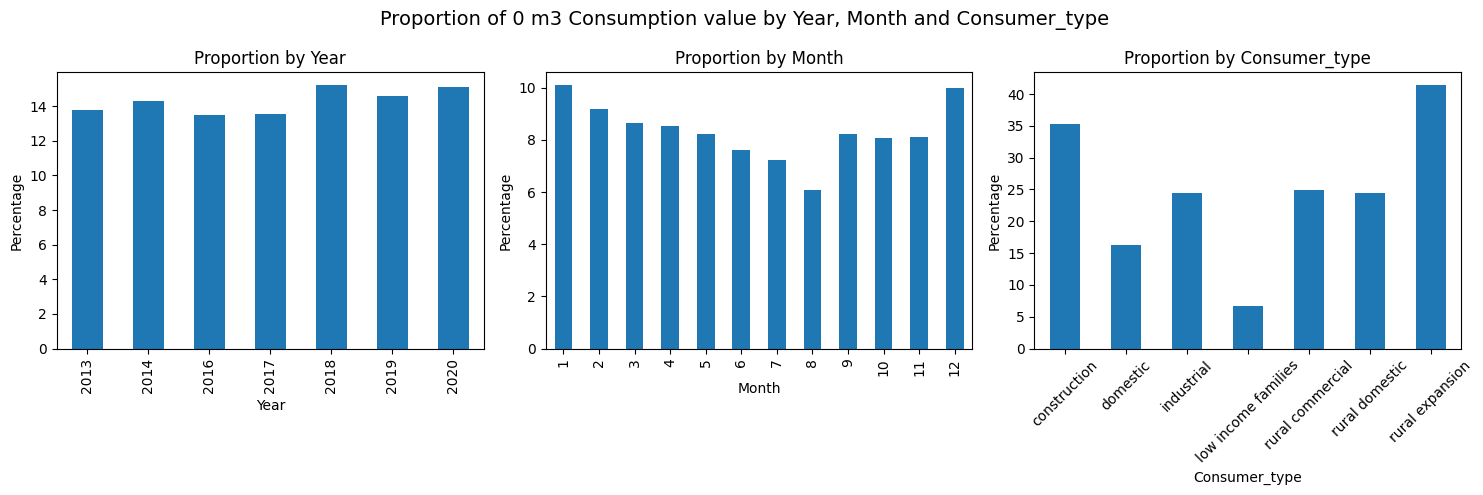

In [ ]:
print('Proportion of 0 m3 Consumption value by year [%]: \n', df[df.Consumption == 0].value_counts(['Year'], normalize=True)*100, sep='', end='\n\n')
print('Proportion of 0 m3 Consumption value by month [%]: \n', df[df.Consumption == 0].value_counts(['Month'], normalize=True)*100, sep='', end='\n\n')
print('Proportion of 0 m3 Consumption value by Consumer_type [%]: \n', df[df.Consumption == 0].groupby('Consumer_type')['Consumer_number'].count()/df.groupby('Consumer_type')['Consumer_number'].count()*100, sep='', end='\n\n')

# Barplot of the above data as percentages
fig, ax = plt.subplots(1,3, figsize=(15,5))
(df[df.Consumption == 0].groupby('Year')['Consumer_number'].count()/len(df[df.Consumption == 0])*100).plot(kind='bar', ax=ax[0])
(df[df.Consumption == 0].groupby('Month')['Consumer_number'].count()/len(df[df.Consumption == 0])*100).plot(kind='bar', ax=ax[1])
(df[df.Consumption == 0].groupby('Consumer_type')['Consumer_number'].count()/df.groupby('Consumer_type')['Consumer_number'].count()*100).plot(kind='bar', ax=ax[2])
ax[0].set_title('Proportion by Year')
ax[1].set_title('Proportion by Month')
ax[2].set_title('Proportion by Consumer_type')
ax[0].set_ylabel('Percentage')
ax[1].set_ylabel('Percentage')
ax[2].set_ylabel('Percentage')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45)
fig.suptitle('Proportion of 0 m3 Consumption value by Year, Month and Consumer_type', fontsize=14)
plt.tight_layout()
plt.show()


#### Percentage of 0 m3 Consumption value for each month and Consumer type

In order to see if there is a different monthly behaviour for each Consumer type, we can plot the percentage of zero values for each month and Consumer type. First, compute the number of zero values by consumer type and month, and then normalize it by each consumer type.

In [55]:
percent_type_month = df[df.Consumption == 0].groupby(['Consumer_type','Month'])['Consumer_number'].count()/df[df.Consumption == 0].groupby('Consumer_type')['Consumer_number'].count()*100
df_type_month = percent_type_month.unstack().T

Consumer_type,construction,domestic,industrial,low income families,rural commercial,rural domestic,rural expansion
Month,,,,,,,
1,11.153359,10.291827,11.349036,19.696970,9.169675,9.138144,10.869565
2,9.505703,9.453214,9.460775,15.151515,8.014440,8.482172,8.695652
3,7.224335,8.837886,8.506911,6.060606,8.303249,8.352276,8.695652
4,8.238276,8.933950,8.779443,10.606061,8.086643,7.514451,8.967391
5,6.210393,8.448437,9.480241,12.121212,8.086643,7.410535,5.706522
6,8.365019,7.804549,8.390111,7.575758,8.158845,6.800026,4.891304
7,6.337136,7.581265,7.591980,7.575758,7.148014,6.377866,2.717391
8,4.816223,6.597258,6.034651,NaN,5.848375,4.884068,4.891304
9,7.224335,9.325994,9.032509,4.545455,6.931408,5.410145,5.978261


(*In order to see the Plotly interactive plots, download and run the notebook in your local machine or in Google Colab. Attached screenshot to visualise the graph without running the notebook.*)

![Percentage of 0 m3 Consumption value for each month and Consumer type](zero-consumption-month-consumer-type.png)

- Interactively filtering the graph traces by consumer, it is clearly visible that the three rural categories have a similar behaviour, with a peak in the months of January and December, and a minimum in the months of June, July and August. Also, the `construction` category shares a comparable trend with them, but with a higher peak in June.

- The `domestic` and `industrial` show a similar and more stable behaviour through the year. `rural domestic` and `rural comercial` also have a similar trend to them until August, when they diverge.

- The `low income families` category has a different behaviour from the rest.


In [59]:
total_counts = df.groupby(['Consumer_type'])['Consumer_number'].count()

fig = go.Figure()

for consumer_type in df['Consumer_type'].unique():
    
    filtered = df_type_month[consumer_type]

    fig.add_trace(go.Scatter(
        mode='lines+markers',
        x=filtered.index,
        y=filtered.values,
        name=f'{consumer_type}',
    ))

fig.update_layout(

    title='Proportion of 0 m3 Consumption value by Month and Consumer Type',
    xaxis_title='Month',
    yaxis_title='Percentage of 0 m3 Consumption',
    xaxis={'ticktext': ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], 
           'tickvals': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
)

fig.show()

In [ ]:
# Substituting 0 values with NaN for easier handling
df_nan = df.copy()
df_nan.Consumption = df_nan.Consumption.replace(0, np.nan)

### Stats by Installation zone

There are 49 Installation zones, but some of the Consumer types categories are concentrated in a few of them. In fact, there are zones where there is only one type of consumer (see heatmap, the numbers represent percentages for each consumer type). This feature could be useful for the classification task.

- Broadly, the ``construction``, ``domestic``, ``industrial`` and ``low income families`` are located in the Installation zones 1 to 4 (with different distribution over them).

- The rural comercial, rural domestic and rural expansion are more evenly distributed over the Installation zones, (specially rural domestic and rural expansion).

In [ ]:
# For each Consumer_type, the Installation_zone where the are the most Consumers
print(df.groupby('Consumer_type')['Installation_zone'].value_counts().groupby(level=0).head(), end='\n\n')

# For each installation zone, the Consumer_type with the highest number of Consumers
print(df.groupby('Installation_zone')['Consumer_type'].value_counts())


Consumer_type        Installation_zone   
construction         Installation_zone 3       733
                     Installation_zone 4       386
                     Installation_zone 2       384
                     Installation_zone 1       230
                     Installation_zone 8        51
domestic             Installation_zone 1     73358
                     Installation_zone 4     63486
                     Installation_zone 3     58190
                     Installation_zone 2     41103
                     Installation_zone 24       15
industrial           Installation_zone 2      6160
                     Installation_zone 4      6020
                     Installation_zone 3      5197
                     Installation_zone 1      3511
                     Installation_zone 16       41
low income families  Installation_zone 3       368
                     Installation_zone 1       322
                     Installation_zone 4       171
                     Installation_zone 2

In [ ]:
cross = df.groupby(['Installation_zone', 'Consumer_type'])['Consumer_number'].count().unstack()
cross.replace(np.nan, 0, inplace=True)

# Normalize for each Consumer_type
freqs = cross/cross.sum(axis=0)*100
freqs = freqs.round(2)

# Reorder the index Installation_zone by ascending number of zone, eg. Installation_zone 1, Installation_zone 2, etc.
freqs = freqs.reindex(sorted(freqs.index, key=lambda x: int(x.split()[1])))
print(freqs)


Consumer_type         construction  domestic  industrial  low income families  rural commercial  rural domestic  rural expansion
Installation_zone                                                                                                               
Installation_zone 1          10.29     31.06       16.67                32.23              0.92            0.00             0.00
Installation_zone 2          17.18     17.40       29.25                11.31             35.07            0.00             1.24
Installation_zone 3          32.80     24.64       24.68                36.84             32.49            0.04             0.11
Installation_zone 4          17.27     26.88       28.59                17.12              0.00            0.03             0.00
Installation_zone 5           1.48      0.00        0.08                 0.00              0.00            3.99             2.25
Installation_zone 6           0.89      0.00        0.00                 0.00              0.00  

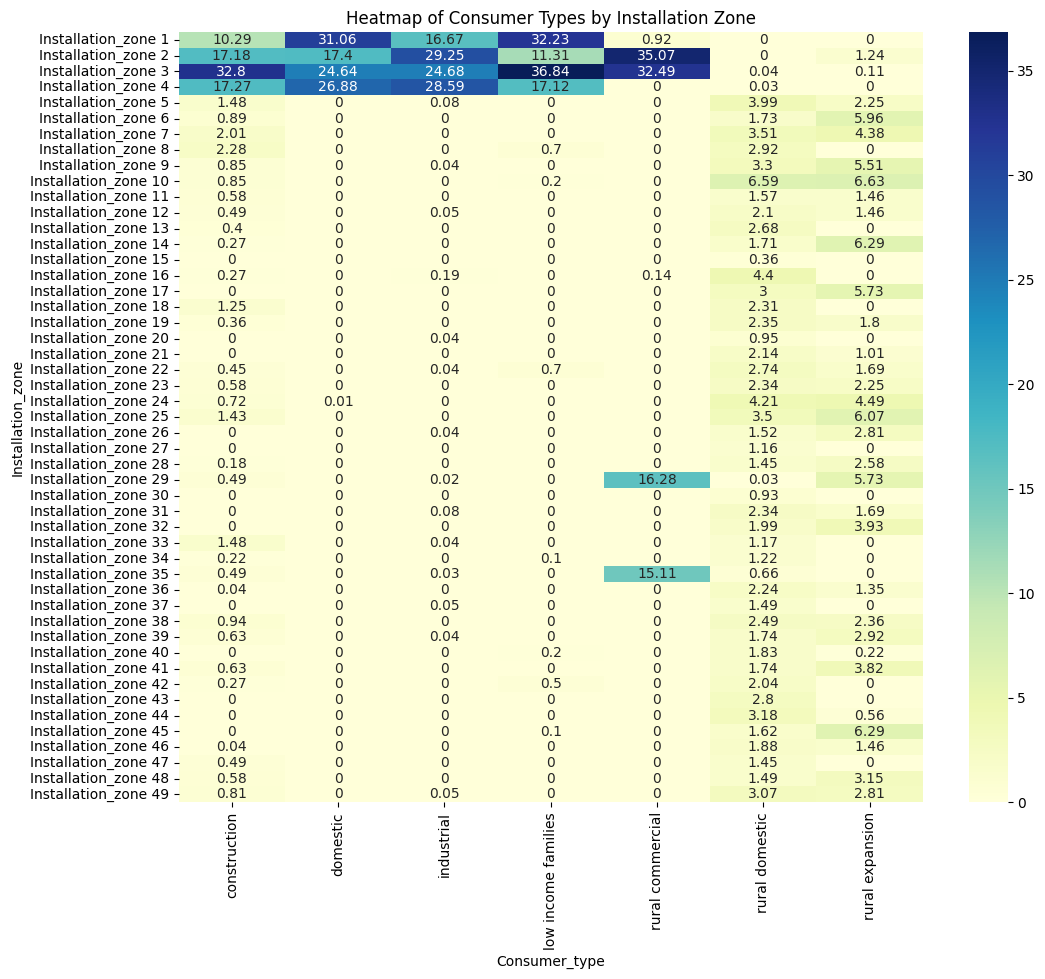

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(freqs, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Heatmap of Consumer Types by Installation Zone")
plt.show()

## Analysis

dataset analysis

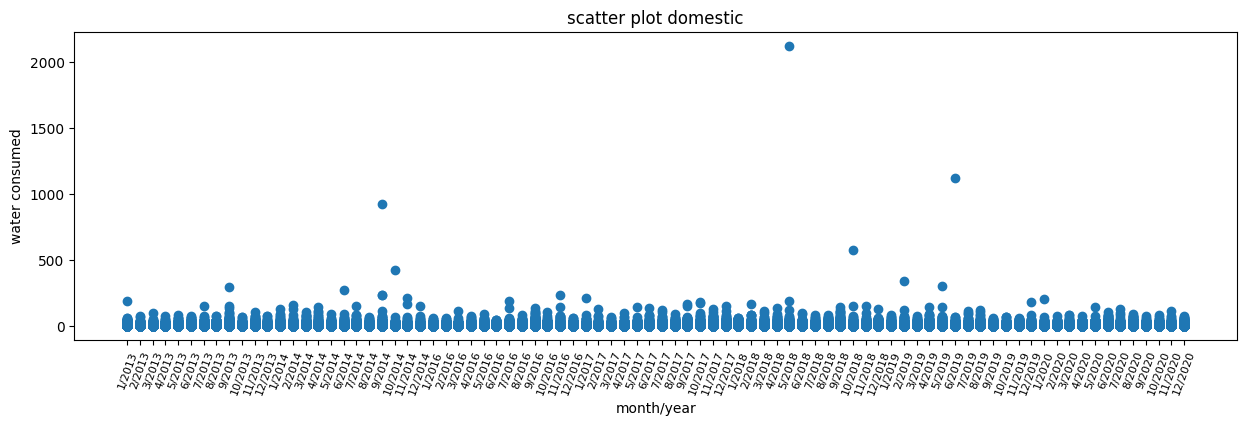

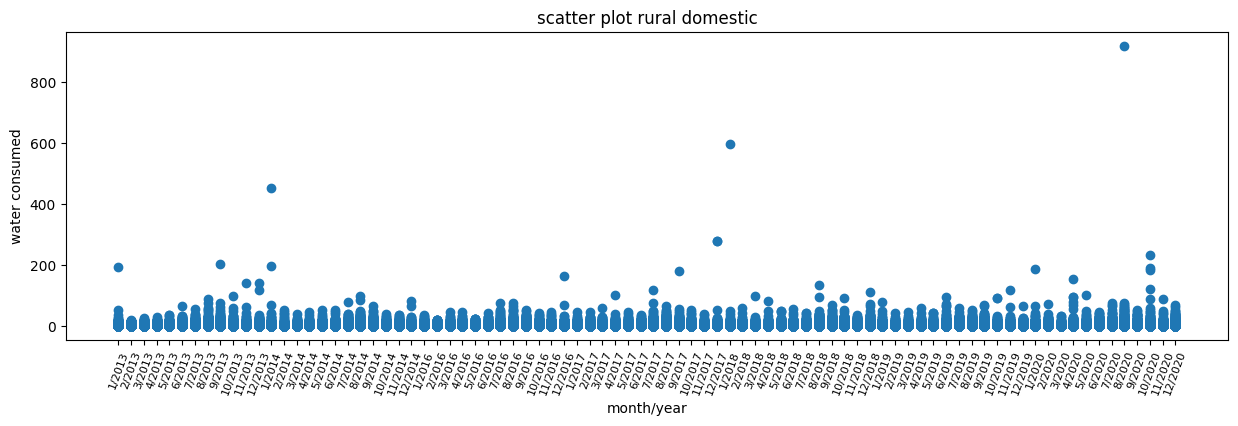

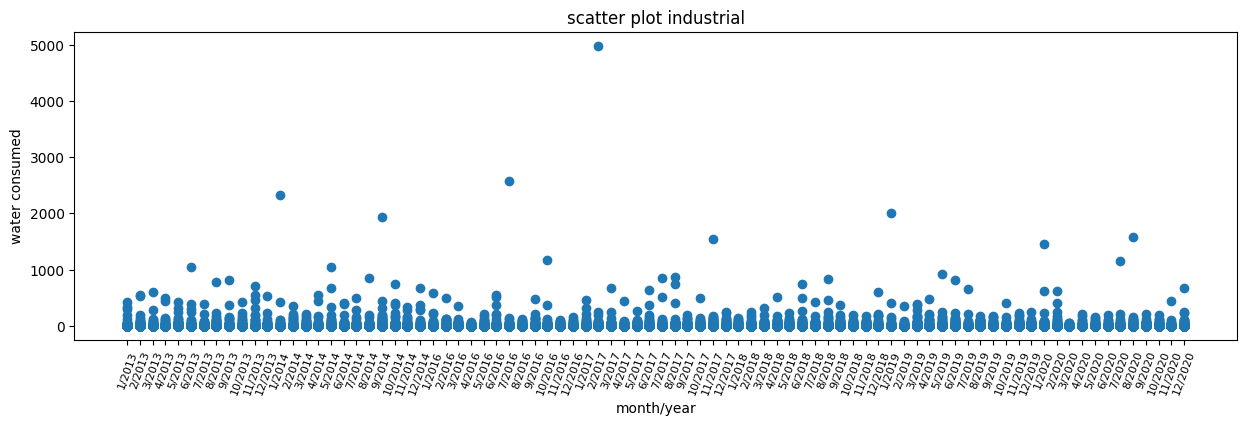

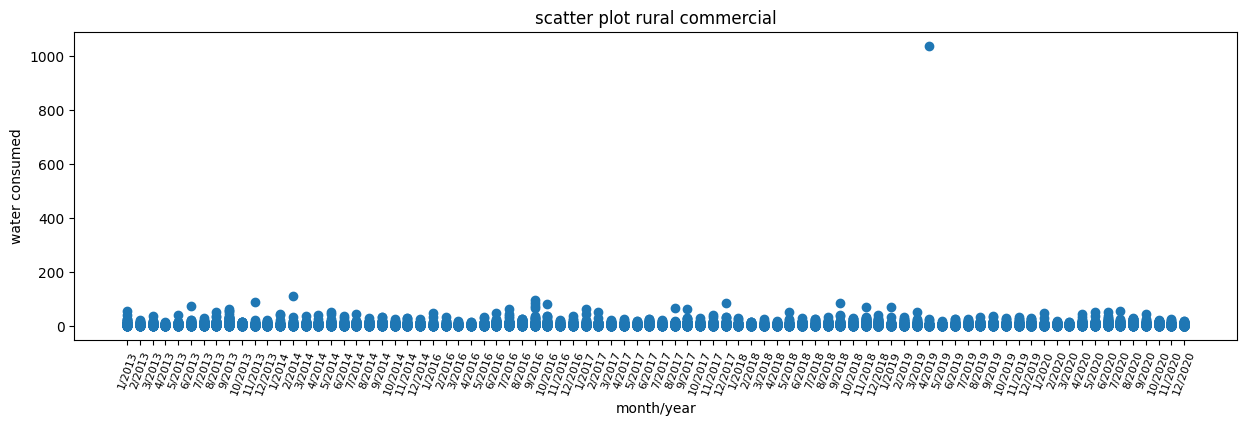

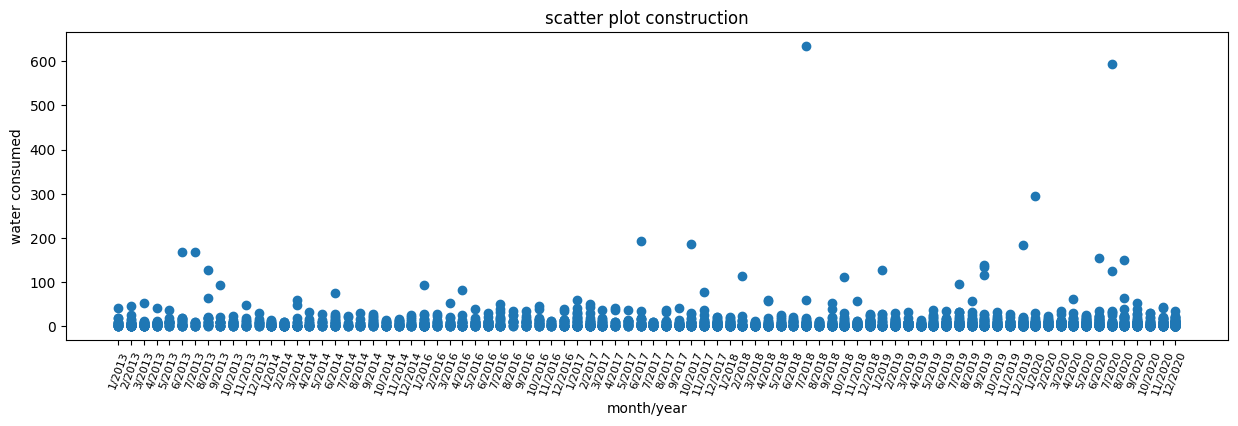

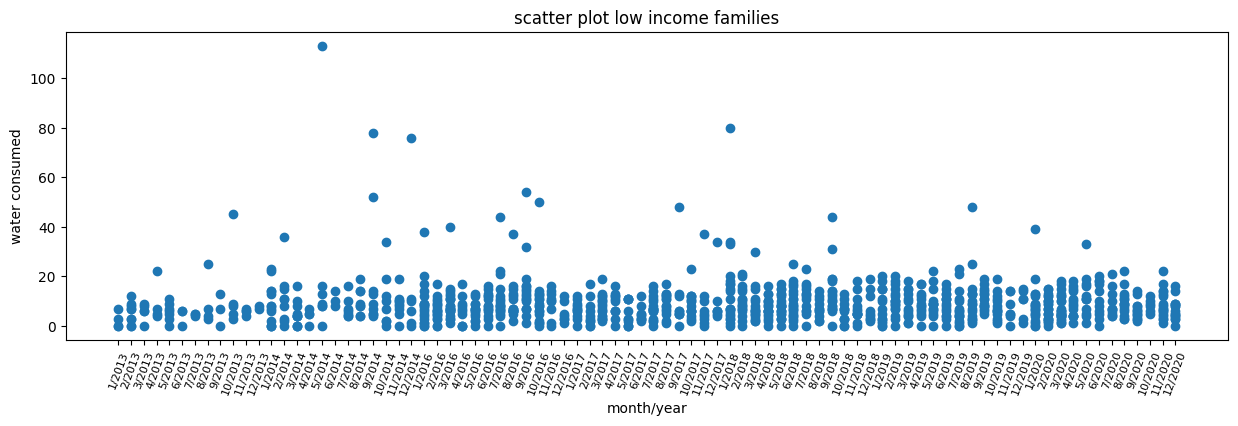

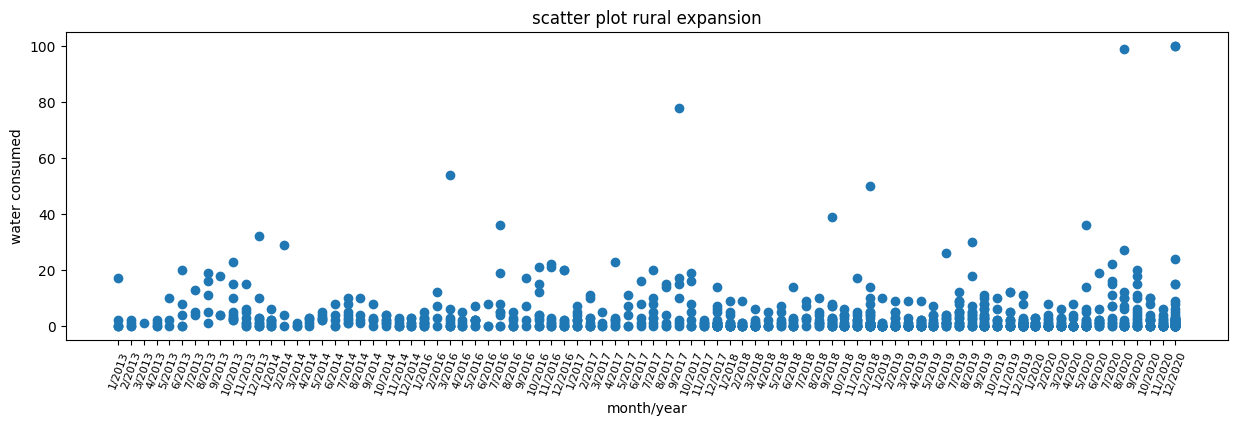

In [ ]:
def scatter_graph(consumertype_df, consumertype,):
  consumertype_df = df.loc[df['Consumer_type'] == consumertype]
  consumer_month = consumertype_df['Month'].astype(str) + '/' + consumertype_df['Year'].astype(str)
  consumer_water_consumed = [consumertype_df['Consumption']]

  plt.figure(figsize=(15,4))
  plt.scatter(consumer_month, consumer_water_consumed)

  plt.title("scatter plot " + consumertype)
  plt.xlabel("month/year")
  plt.ylabel("water consumed")
  plt.xticks(rotation=70, size=8)
  plt.show()

scatter_graph("domestic_df", "domestic")
scatter_graph("rural_domestic_df", "rural domestic")
scatter_graph("industrial_df", "industrial")
scatter_graph("rural_commercial_df", "rural commercial")
scatter_graph("construction_df", "construction")
scatter_graph("low_income_families_df", "low income families")
scatter_graph("rural_expansion_df", "rural expansion")

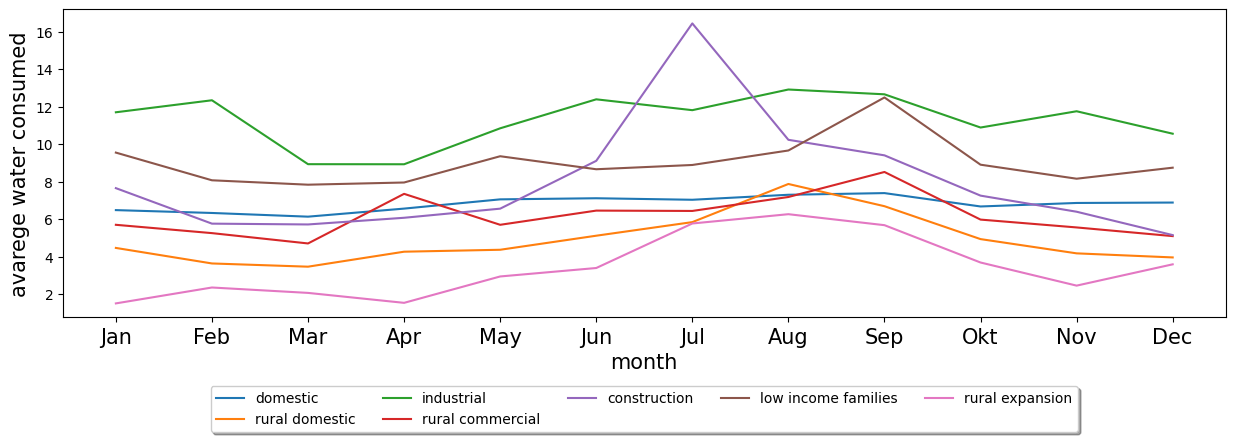

In [ ]:
xlabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec']
plt.figure(figsize=(15,4))

def monthly_avarage_consumption(consumertype_df, consumertype):
  consumertype_df = df.loc[df['Consumer_type'] == consumertype]
  avg_consumption = consumertype_df[['Month', 'Consumption']].groupby('Month').mean()
  plt.plot(xlabels, avg_consumption, label=consumertype)

monthly_avarage_consumption("domestic_df", "domestic")
monthly_avarage_consumption("rural_domestic_df", "rural domestic")
monthly_avarage_consumption("industrial_df", "industrial")
monthly_avarage_consumption("rural_commercial_df", "rural commercial")
monthly_avarage_consumption("construction_df", "construction")
monthly_avarage_consumption("low_income_families_df", "low income families")
monthly_avarage_consumption("rural_expansion_df", "rural expansion")

plt.xlabel("month", size=15)
plt.ylabel("avarege water consumed", size=15)
plt.xticks(size=15)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)

plt.show()

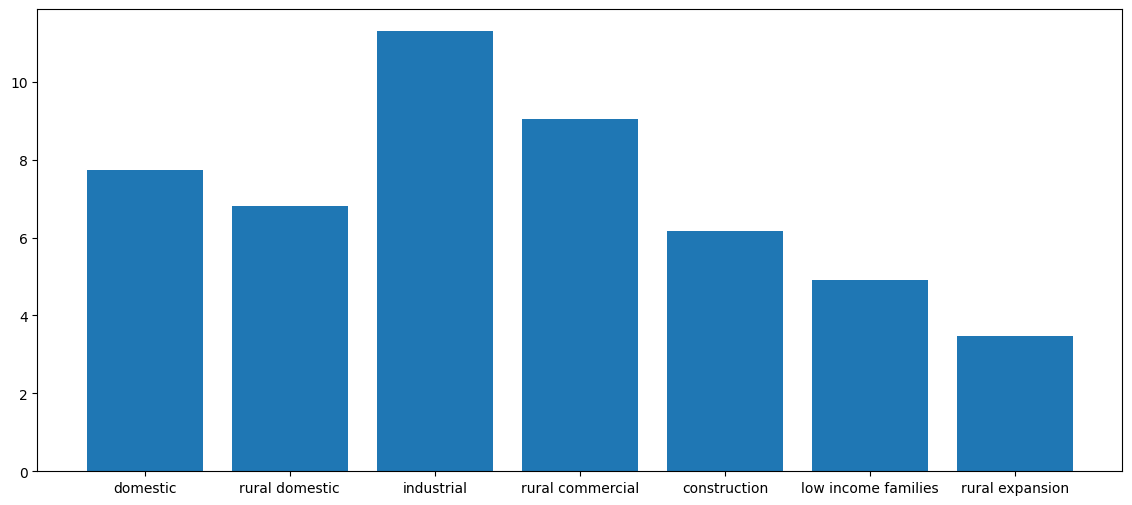

In [ ]:
xlabels = ('domestic', 'rural domestic', 'industrial', 'rural commercial', 'construction', 'low income families', 'rural expansion')
avarage_consumption = df[['Consumption', 'Consumer_type']].groupby('Consumer_type').mean()
plt.figure(figsize=(14,6))
plt.bar(xlabels, avarage_consumption.Consumption)


plt.show()

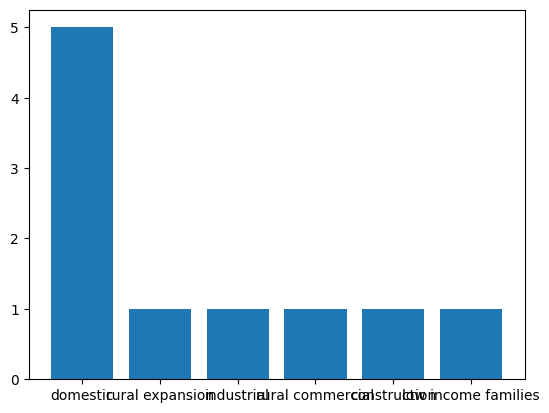

<function matplotlib.pyplot.show(close=None, block=None)>

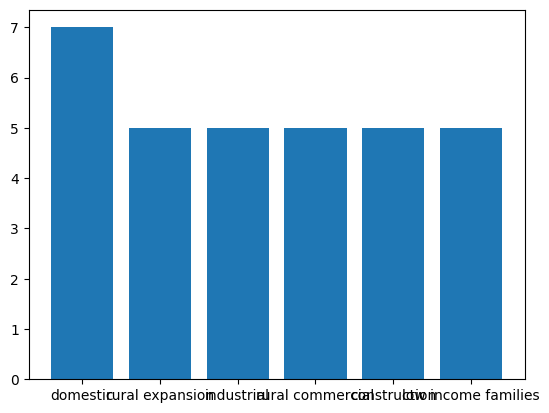

In [ ]:
nozero_df = df.loc[df['Consumption'] != 0]
xlabels = ('domestic', 'rural expansion', 'industrial', 'rural commercial', 'construction', 'low income families', 'rural expansion')

domestic_list = nozero_df.loc[nozero_df['Consumer_type'] == 'domestic'] ['Consumption'].tolist()
rural_domestic_list = nozero_df.loc[nozero_df['Consumer_type'] == 'rural domestic']['Consumption'].tolist()
industrial_list = nozero_df.loc[nozero_df['Consumer_type'] == 'rural domestic']['Consumption'].tolist()
rural_commercial_list = nozero_df.loc[nozero_df['Consumer_type'] == 'rural domestic']['Consumption'].tolist()
construction_list = nozero_df.loc[nozero_df['Consumer_type'] == 'rural domestic']['Consumption'].tolist()
low_income_families_list = nozero_df.loc[nozero_df['Consumer_type'] == 'rural domestic']['Consumption'].tolist()
rural_expansion_list = nozero_df.loc[nozero_df['Consumer_type'] == 'rural domestic']['Consumption'].tolist()

mode_consumption = [statistics.mode(domestic_list),
                    statistics.mode(rural_domestic_list),
                    statistics.mode(industrial_list),
                    statistics.mode(rural_commercial_list),
                    statistics.mode(construction_list),
                    statistics.mode(low_income_families_list),
                    statistics.mode(rural_expansion_list),
                    ]

median_consumption = [statistics.median(domestic_list),
                      statistics.median(rural_domestic_list),
                      statistics.median(industrial_list),
                      statistics.median(rural_commercial_list),
                      statistics.median(construction_list),
                      statistics.median(low_income_families_list),
                      statistics.median(rural_expansion_list),
                    ]

plt.bar(xlabels, mode_consumption)
plt.show()

plt.bar(xlabels, median_consumption)
plt.show

## Features

dataset features


## Model


model building

# Evaluation

evaluating model


## Prediction


prediction
